In [23]:
import numpy as np
from numba import njit, prange
import time
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [24]:
# Initial conditions of grid
nx, ny = 2048, 2048 # grid size
dx, dy = 1.0 / nx, 1.0 / ny
dt = 0.00000005 # time step
nt = 100 # number of steps

In [25]:
# Flow parameters
nu = 0.1 # viscosity
rho = 1.0 # density

In [26]:
# Arrays initializing
u = np.zeros((nx, ny))  # speed (x)
v = np.zeros((nx, ny))  # speed (y) 
p = np.zeros((nx, ny))  # pressure

In [27]:
# Initial conditions for turbulence: localized vortex
u[nx//4:nx//4+10, ny//4:ny//4+10] = 1.0
v[nx//4:nx//4+10, ny//4:ny//4+10] = 1.0

In [28]:
def navier_stokes(u, v, p, nu, rho, dx, dy, dt, nt):
    for n in range(nt):
        un = u.copy()
        vn = v.copy()
        
        # Non-linear part
        u[1:-1, 1:-1] = un[1:-1, 1:-1] - un[1:-1, 1:-1] * dt / dx * (un[1:-1, 1:-1] - un[:-2, 1:-1]) - \
                        vn[1:-1, 1:-1] * dt / dy * (un[1:-1, 1:-1] - un[1:-1, :-2])
        v[1:-1, 1:-1] = vn[1:-1, 1:-1] - un[1:-1, 1:-1] * dt / dx * (vn[1:-1, 1:-1] - vn[:-2, 1:-1]) - \
                        vn[1:-1, 1:-1] * dt / dy * (vn[1:-1, 1:-1] - vn[1:-1, :-2])
        
        # Dissipation part
        u[1:-1, 1:-1] += nu * dt * ((un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[:-2, 1:-1]) / dx**2 +
                                    (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, :-2]) / dy**2) + 1e-8
        v[1:-1, 1:-1] += nu * dt * ((vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[:-2, 1:-1]) / dx**2 +
                                    (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, :-2]) / dy**2) + 1e-8
        
        # Boundary conditions
        u[0, :], u[-1, :], u[:, 0], u[:, -1] = 0, 0, 0, 0
        v[0, :], v[-1, :], v[:, 0], v[:, -1] = 0, 0, 0, 0
    return u, v

In [29]:
@njit(parallel=True)
def navier_stokes_numba(u, v, p, nu, rho, dx, dy, dt, nt):
    for n in range(nt):
        un = u.copy()
        vn = v.copy()
        for i in prange(1, u.shape[0] - 1):
            for j in range(1, u.shape[1] - 1):
                u[i, j] = un[i, j] - un[i, j] * dt / dx * (un[i, j] - un[i - 1, j]) - \
                          vn[i, j] * dt / dy * (un[i, j] - un[i, j - 1]) + \
                          nu * dt * ((un[i + 1, j] - 2 * un[i, j] + un[i - 1, j]) / dx**2 +
                                     (un[i, j + 1] - 2 * un[i, j] + un[i, j - 1]) / dy**2) + 1e-8
                v[i, j] = vn[i, j] - un[i, j] * dt / dx * (vn[i, j] - vn[i - 1, j]) - \
                          vn[i, j] * dt / dy * (vn[i, j] - vn[i, j - 1]) + \
                          nu * dt * ((vn[i + 1, j] - 2 * vn[i, j] + vn[i - 1, j]) / dx**2 +
                                     (vn[i, j + 1] - 2 * vn[i, j] + vn[i, j - 1]) / dy**2) + 1e-8
        u[0, :], u[-1, :], u[:, 0], u[:, -1] = 0, 0, 0, 0
        v[0, :], v[-1, :], v[:, 0], v[:, -1] = 0, 0, 0, 0
    return u, v

Gpu

In [ ]:
start = time.time()
u_base, v_base = navier_stokes(u.copy(), v.copy(), p.copy(), nu, rho, dx, dy, dt, nt)
print("Base time:", time.time() - start)

start = time.time()
u_numba, v_numba = navier_stokes_numba(u.copy(), v.copy(), p.copy(), nu, rho, dx, dy, dt, nt)
print("Numba time:", time.time() - start)

Base time: 0.000102996826171875
Numba time: 7.700717926025391


In [31]:
def check_stability(dx, dy, dt, nu):
    # Courant criterion
    max_speed = np.sqrt(2 * nu / (dx**2 + dy**2))
    cfl_condition = max_speed * dt / min(dx, dy)
    return cfl_condition < 0.5

In [32]:
# Stability check
is_stable = check_stability(dx, dy, dt, nu)
print("Stability check passed:", is_stable)

Stability check passed: True


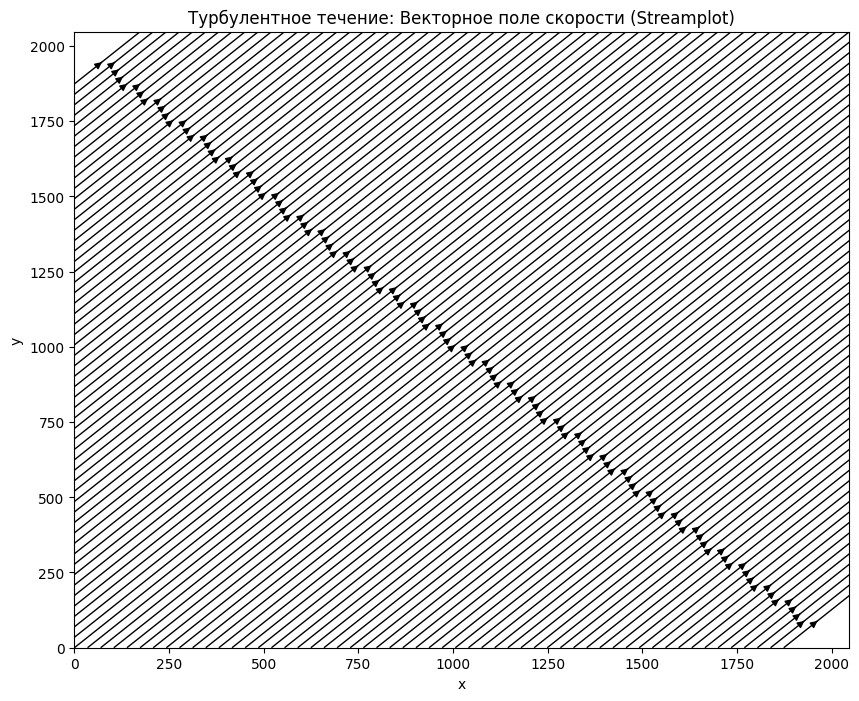

In [33]:
plt.figure(figsize=(10, 8))
X, Y = np.meshgrid(np.arange(nx), np.arange(ny))
plt.streamplot(X, Y, u_numba, v_numba, color='k', linewidth=1, density=2)
plt.title("Турбулентное течение: Векторное поле скорости (Streamplot)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()